In [152]:
import requests
from bs4 import BeautifulSoup
import os
import re
import pandas as pd

# будем отображать графики прямо в jupyter'e
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 

#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5

from textwrap import wrap
import humanize

In [3]:
# establishing session
s = requests.Session()
s.headers.update({
    'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_2) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/71.0.3578.98 Safari/537.36'
    })

In [4]:
MONTHS = ('января', 'февраля', 'марта', 'апреля', 'мая', 'июня', 'июля', 'августа', 'сентября', 'октября', 'ноября', 'декабря')
MONTHS_DICT = {MONTHS[i]: i + 1 for i in range(len(MONTHS))}

# Загрузка html-страниц с заявками

In [5]:
def load_user_data(page, session):
    url = f'https://kontur.userecho.com/communities/2-konturbuhgalteriya/topics?page={page}'
    request = session.get(url)
    return request.text

In [6]:
for page in range(1, 93):
    data = load_user_data(page, s)
    with open(f'./pages/page_{page}.html', 'w') as output_file:
        output_file.write(data)

# Парсинг html-страницы

In [98]:
def parse_user_datafile_bs(filename):
    results = []
    file_out = open(filename, "r")
    text = file_out.read()
        
    soup = BeautifulSoup(text)
    topic_list = soup.find('div', {'class': 'topiclist-topics'})
    items = topic_list.find_all('div', {'class': 'topic-item topic-item-medium-list'})
    for item in items:
        topic_id = item.get('id')
        
        topic_page = int(re.search(r'(\d{1,2})', filename).group(1))
        
        # topic_item
        topic_votes = int(item.find('div').find('div', {'class': 'topic-votes pull-right'}).find('span').text)
        
        topic_status = item.find('div').find('div', {'class': 'topic-status'}).find('span').text
        if topic_status == '':
            topic_status = 'Необработанные'
            
        topic_actions = item.find('div').find('ul', {'class': 'topic-actions'}).get('data-topic-id')
        topic_type = item.find('div').find('h3', {'class': 'topic-header'}).find('span', {'class': 'topic-type-image'}).get('title')
        topic_link = 'https://kontur.userecho.com' + item.find('div').find('h3', {'class': 'topic-header'}).find('a').get('href')
        topic_header = item.find('div').find('h3', {'class': 'topic-header'}).find('a').text
        topic_creater = item.find('div').find('div', {'class': 'topic-details'}).find('a', {'class': 'ajax-popover'}).text
        topic_text = item.find('div').find('div', {'class': 'topic-text'}).text
        topic_comments = item.find('div').find('div', {'class': 'topic-details'}).find('a', {'target': '_self'}).text
        
        topic_tags = item.find('div').find('div', {'class': 'topic-tags'}).text
        topic_tags = topic_tags[1:len(topic_tags) - 2]
        
        # topic_date
        topic_date_created = item.find('div').find('div', {'class': 'topic-details'}).find('span', {'class': 'date-created'}).get('title')
        topic_date_day = int(re.search(r'(^\d+\b)', topic_date_created).group(1))
        topic_date_month = MONTHS_DICT[re.search(r'(\b[а-я]+(а|я)\b)', topic_date_created).group(1)]
        topic_date_year = int(re.search(r'(\d{4})', topic_date_created).group(1))
        
        # topic_solution
        topic_solution = item.find('div', {'class': 'topic-solution'})
        if topic_solution:
            solution_creater = topic_solution.find('div', {'class': 'topic-details'}).find('a').text
            solution_text = topic_solution.find('div', {'class': 'topic-text'}).text
            
            solution_date_created = topic_solution.find('div', {'class': 'topic-details'}).find('span').get('title')
            solution_date_day = int(re.search(r'(^\d+\b)', solution_date_created).group(1))
            solution_date_month = MONTHS_DICT[re.search(r'(\b[а-я]+(а|я)\b)', solution_date_created).group(1)]
            solution_date_year = int(re.search(r'(\d{4})', solution_date_created).group(1))
        else:
            solution_creater = float('nan')
            solution_text = float('nan')
            
            solution_date_created = float('nan')
            solution_date_day = float('nan')
            solution_date_month = float('nan')
            solution_date_year = float('nan')
            
        results.append({
            'topic_page': topic_page,
            'topic_id': topic_id,
            'topic_votes': topic_votes,
            'topic_status': topic_status,
            'topic_actions': topic_actions,
            'topic_type': topic_type,
            'topic_link': topic_link,
            'topic_header': topic_header,
            'topic_creater': topic_creater,
            'topic_date_day': topic_date_day,
            'topic_date_month': topic_date_month,
            'topic_date_year': topic_date_year,
            'topic_text': topic_text,
            'topic_comments': topic_comments,
            'topic_tags': topic_tags,
            'solution_creater': solution_creater,
            'solution_date_day': solution_date_day,
            'solution_date_month': solution_date_month,
            'solution_date_year': solution_date_year,
            'solution_text': solution_text
            })
    file_out.close()
    return results

In [126]:
results = []

# parsing data
for filename in os.listdir('./pages/'):
    try:
        results.extend(parse_user_datafile_bs('./pages/' + filename))
    except:
        print(filename)
    
# parsing data from one file
# results.extend(parse_user_datafile_bs('./pages/page_1.html'))
# results.extend(parse_user_datafile_bs('./pages/page_2.html'))

.DS_Store


In [127]:
data_df = pd.DataFrame(results)
data_df.head()

,solution_creater,solution_date_day,solution_date_month,solution_date_year,solution_text,topic_actions,topic_comments,topic_creater,topic_date_day,topic_date_month,topic_date_year,topic_header,topic_id,topic_link,topic_page,topic_status,topic_tags,topic_text,topic_type,topic_votes
0,NaN,NaN,NaN,NaN,NaN,4469,2,chesnokova,20,7,2017,Перенос 30234 с КВФО 7на КВФО5,topic-4469,https://kontur.userecho.com/communities/2/topi...,82,Завершен,,Предоставили субсидии на иные цели на погашени...,Идеи,0
1,NaN,NaN,NaN,NaN,NaN,4463,2,ЮлияК,18,7,2017,Накладная ТОРГ - 12 Н,topic-4463,https://kontur.userecho.com/communities/2/topi...,82,Отклонен,,"Добрый день, хотелось бы видеть в Документах ф...",Идеи,0
2,NaN,NaN,NaN,NaN,NaN,4399,2,Personal Virtual Assistant,20,6,2017,"Программа не доработана вообще,сдаю нулевую де...",topic-4399,https://kontur.userecho.com/communities/2/topi...,82,Завершен,,,Претензии,0
3,NaN,NaN,NaN,NaN,NaN,4391,1,gof3s,16,6,2017,плательщик и грузополучатель!!!!,topic-4391,https://kontur.userecho.com/communities/2/topi...,82,На рассмотрении,,Сделайте пожалуйста возможность вносить плател...,Идеи,0
4,NaN,NaN,NaN,NaN,NaN,4337,1,Юлия Александровна,22,5,2017,Возможно ли списком посмотреть неоплаченные вы...,topic-4337,https://kontur.userecho.com/communities/2/topi...,82,Отвечен,,,Вопросы,0


# Аналитика

* Данные по статусам и типам задач

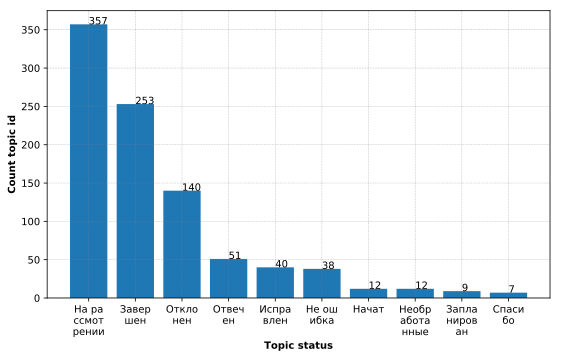

In [130]:
group_by = ['topic_status']

data_df_group = pd.DataFrame({'count_topic_id' : data_df.groupby(group_by)['topic_id'].count()}).reset_index()
data_df_group.sort_values(by=['count_topic_id'], inplace=True, ascending=False)

data_df_group.topic_status = ['\n'.join(wrap(l, 5)) for l in data_df_group.topic_status]

fig = plt.figure()
axes = fig.add_axes([0.1, 0.1, 0.7, 0.8])
axes.bar(data_df_group.topic_status, data_df_group.count_topic_id)
axes.set_xlabel('Topic status', weight='bold')
axes.set_ylabel('Count topic id', weight='bold')
axes.grid(color='gray', alpha=0.5, linestyle='dashed', linewidth=0.5)

for i, j in zip(data_df_group.topic_status, data_df_group.count_topic_id):
    axes.annotate(j, xy=(i, j))

Самый распространенный статус - "На рассмотрении", т.к. много идей, которые можно рассмотреть при наличии соответствующих отзувов от клиентов. Среди них, а так же среди "Необработанные" и будем искать топики, которые необходимо выделить для скорейшего решения. Остальные топики (включая статусы "Начат" и "Запланирован", т.к. они уже взяты в работу и поставлены в очередь)

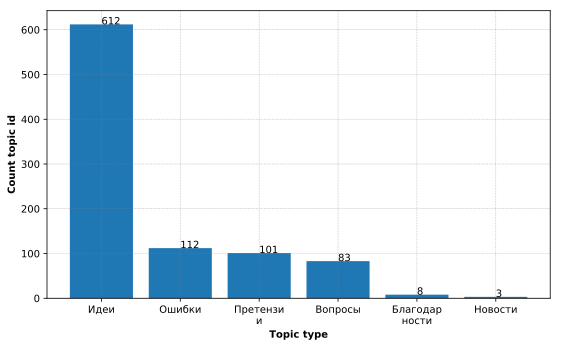

In [131]:
group_by = ['topic_type']

data_df_group = pd.DataFrame({'count_topic_id' : data_df.groupby(group_by)['topic_id'].count()}).reset_index()
data_df_group.sort_values(by=['count_topic_id'], inplace=True, ascending=False)

data_df_group.topic_type = ['\n'.join(wrap(l, 8)) for l in data_df_group.topic_type]

fig = plt.figure()
axes = fig.add_axes([0.1, 0.1, 0.7, 0.8])
axes.bar(data_df_group.topic_type, data_df_group.count_topic_id)
axes.set_xlabel('Topic type', weight='bold')
axes.set_ylabel('Count topic id', weight='bold')
axes.grid(color='gray', alpha=0.5, linestyle='dashed', linewidth=0.5)

for i, j in zip(data_df_group.topic_type, data_df_group.count_topic_id):
    axes.annotate(j, xy=(i, j))

Самый распространенный тип топиков - "Идеи". Видно, что пользователи приходят с предложениями по улучшению сервиса. Но в первую очередь поиск топиков к скорейшему решению необходимо начинать среди Ошибок, Претензий и Вопросов, т.к. там могут быть критичные ошибки, которые необходимо исправить, а так же срочные вопросы и претензии, которые можно будет решить без затрат времени на разработку, только силами сотрудников тех.поддержки

***
* Первые в группе риска - необработанные ошибки. Их надо смотреть в первую очередь, т.к. в них могут быть указаны критические ошибки работы системы:

In [132]:
data_df[(data_df.topic_status == 'Необработанные') & (data_df.topic_type == 'Ошибки')].iloc[:, 5:]

,topic_actions,topic_comments,topic_creater,topic_date_day,topic_date_month,topic_date_year,topic_header,topic_id,topic_link,topic_page,topic_status,topic_tags,topic_text,topic_type,topic_votes
222,6077,1,gaebr,9,12,2018,личная встреча и выписка из банка,topic-6077,https://kontur.userecho.com/communities/2/topi...,71,Необработанные,,"сразу бросается 2 беды у контура, чего нет у о...",Ошибки,0
427,4156,1,ЮлияБ,4,4,2017,Платежи от физ лиц,topic-4156,https://kontur.userecho.com/communities/2/topi...,32,Необработанные,Банковская выписка,При экспорте выписок от физ лиц теряется само ...,Ошибки,6
499,6216,0,3gstudio,22,1,2019,проблемы,topic-6216,https://kontur.userecho.com/communities/2/topi...,69,Необработанные,,произвожу ввод остатков товара на начало. я не...,Ошибки,0


В выборке три топика. Два из них - 2017 и 2018 годов с 1 комментарием каждая. Эти комментарии оставили сотрудники тех.поддержки с уточняющими вопросами. Ответы на них не получены, следовательно, в рассмотрение эти топики в рассмотрение не берем.  

Третий топик имеет следующий текст:

In [141]:
results[499]['topic_text']

'произвожу ввод\xa0остатков товара на начало. я не плательщик НДС. у меня упрощенка. зачем у меня аж 2 вкладки НДС которые я постоянно ставлю на "без НДС" в каждой заносимой\xa0единице!! это же элементарно, что они не нужны и должны автоматом отключаться или уже стоять на "без НДС"зато в остатках я не могу выставить\xa0поставщика товара.\xa0нету такой вкладки.\xa0товар с неба. почему? программе не 2 месяца от роду, а\xa0такие нелепости.\xa0'

In [175]:
results[499]['topic_link']

'https://kontur.userecho.com/communities/2/topics/6216-problemyi'

Как видно, это скорее всего не ошибка, которую надо срочно устранять, а вопрос пользователя, с которым ему сможет помочь сотрудник тех.поддержки, предоставив консультацию.  
**Данный топик - 1 на рассмотрение ($ \href{https://kontur.userecho.com/communities/2/topics/6216-problemyi}{topic-6216} $)**, т.к. скорость реакции влияет на мнение пользователей о продукции и повышает уровень сервиса

* Далее - необработанные претензии, возможно среди них есть те, на которые надо срочно отреагировать:

In [134]:
data_df[(data_df.topic_status == 'Необработанные') & (data_df.topic_type == 'Претензии')].iloc[:, 5:]

,topic_actions,topic_comments,topic_creater,topic_date_day,topic_date_month,topic_date_year,topic_header,topic_id,topic_link,topic_page,topic_status,topic_tags,topic_text,topic_type,topic_votes
833,6022,5,Гончарук Алексей,24,11,2018,Переезд на другой сервис бухгалтерии,topic-6022,https://kontur.userecho.com/communities/2/topi...,58,Необработанные,,Буду описывать как наша компания меняет сервис...,Претензии,1


Единственная необработанная претензия - рассказ клиента, как они переходят на другой сервис. На вопрос специалиста тех.поддержки, что клиента не устроило в Бухгалтерии, ответа нет. Данные топик в рассмотрение не берем  

* Необработанные вопросы:

In [174]:
data_df[(data_df.topic_status == 'Необработанные') & (data_df.topic_type == 'Вопросы')].iloc[:, 5:]

,topic_actions,topic_comments,topic_creater,topic_date_day,topic_date_month,topic_date_year,topic_header,topic_id,topic_link,topic_page,topic_status,topic_tags,topic_text,topic_type,topic_votes
506,6170,10,Aleksandr88,9,1,2019,Контур. Маркировка. Табак,topic-6170,https://kontur.userecho.com/communities/2/topi...,69,Необработанные,,Добрый день. Для системы учета табака ИС МОТП ...,Вопросы,0


На данный вопрос клиента были предоставлены развернутые ответы сотрудников компании

* Далее рассмотрим, какие есть статусы у топиков, помеченных как "Ошибки"

In [135]:
set(data_df[(data_df.topic_status != 'Необработанные') & (data_df.topic_type == 'Ошибки')].topic_status)

{'Запланирован', 'Исправлен', 'На рассмотрении', 'Начат', 'Не ошибка'}

* Посмотрим топики с типам "Ошибки" со статусом "На рассмотрении", не имеющие ответа

In [163]:
group_by = ['topic_date_year', 'topic_date_month', 'topic_comments', 'topic_votes']


data_df_group = data_df[(data_df.topic_status == 'На рассмотрении') & 
        (data_df.topic_type == 'Ошибки')  & 
        (data_df.solution_creater.isna())].sort_values(by=['topic_votes'], ascending=False).iloc[:, 5:]
data_df_group = pd.DataFrame({'count_topic_id' : data_df_group.groupby(group_by)['topic_id'].count()}).reset_index()

data_df_group

,topic_date_year,topic_date_month,topic_comments,topic_votes,count_topic_id
0,2014,4,2,9,1
1,2014,10,4,3,1
2,2015,5,1,7,1
3,2016,1,7,21,1
4,2016,5,2,13,1
5,2016,6,1,7,1
6,2016,12,2,10,1
7,2017,4,6,3,1
8,2017,7,2,0,1
9,2017,8,1,1,2


Как видно, свежих топиков нет, самый последний - от декабря 2018 года, до этого - июль 2018 года. Все топики прокомментированы. Некоторые топики являются не ошибками, а идеями, которые принимаются в реализацию по итогам голосования.  

Декабрьский топик:

In [165]:
data_df[(data_df.topic_status == 'На рассмотрении') & 
        (data_df.topic_type == 'Ошибки')  & 
        (data_df.solution_creater.isna()) &
        (data_df.topic_date_year == 2018) &
        (data_df.topic_date_month == 12)].sort_values(by=['topic_votes'], ascending=False).iloc[:, 5:]

,topic_actions,topic_comments,topic_creater,topic_date_day,topic_date_month,topic_date_year,topic_header,topic_id,topic_link,topic_page,topic_status,topic_tags,topic_text,topic_type,topic_votes
334,6125,2,Ирина2018,21,12,2018,"юридический адрес как в ЕГРЮЛ для счетов, акто...",topic-6125,https://kontur.userecho.com/communities/2/topi...,70,На рассмотрении,,,Ошибки,0


In [166]:
results[334]['topic_link']

'https://kontur.userecho.com/communities/2/topics/6125-yuridicheskij-adres-kak-v-egryul-dlya-schetov-aktov-nakladnyih'

Топик так же является не ошибкой, а идеей, которая будет принята в реализацию по итогам голосования.  

* Посмотрим топики с типам "Претензии" со статусом "На рассмотрении", не имеющие ответа

In [167]:
group_by = ['topic_date_year', 'topic_date_month', 'topic_comments', 'topic_votes']


data_df_group = data_df[(data_df.topic_status == 'На рассмотрении') & 
        (data_df.topic_type == 'Претензии')  & 
        (data_df.solution_creater.isna())].sort_values(by=['topic_votes'], ascending=False).iloc[:, 5:]
data_df_group = pd.DataFrame({'count_topic_id' : data_df_group.groupby(group_by)['topic_id'].count()}).reset_index()

data_df_group

,topic_date_year,topic_date_month,topic_comments,topic_votes,count_topic_id
0,2015,2,6,29,1
1,2015,5,7,32,1
2,2016,3,3,11,1
3,2016,5,2,5,1
4,2016,7,6,16,1
5,2017,1,2,4,1
6,2017,2,5,30,1
7,2017,3,1,11,1
8,2017,6,1,3,1
9,2017,11,1,11,1


Как видно, есть один свежий топик и пара от конца прошлого года, до этого - август 2018 года. Все топики прокомментированы. Некоторые топики являются не ошибками, а идеями, которые принимаются в реализацию по итогам голосования.  

Три последних топика:

In [170]:
data_df[(data_df.topic_status == 'На рассмотрении') & 
        (data_df.topic_type == 'Претензии')  & 
        (data_df.solution_creater.isna()) &
        (((data_df.topic_date_year == 2018) & (data_df.topic_date_month >= 10)) | 
        (data_df.topic_date_year == 2019))].sort_values(by=['topic_votes'], ascending=False).iloc[:, 5:]

,topic_actions,topic_comments,topic_creater,topic_date_day,topic_date_month,topic_date_year,topic_header,topic_id,topic_link,topic_page,topic_status,topic_tags,topic_text,topic_type,topic_votes
336,6113,2,Алексей Седых,18,12,2018,Мертвая поддержка,topic-6113,https://kontur.userecho.com/communities/2/topi...,70,На рассмотрении,,"Сервис бухгалтерский, а в поддержке сидят то л...",Претензии,0
500,6215,2,Елена Варивода,21,1,2019,Вопрос к разработчику программы. Почему не раб...,topic-6215,https://kontur.userecho.com/communities/2/topi...,69,На рассмотрении,,Вопрос к разработчику программы. Почему не раб...,Претензии,0
612,5861,3,Вероника Сергеевна,10,10,2018,Кудир в word???? вы шутите???? верните exel!!!!!!,topic-5861,https://kontur.userecho.com/communities/2/topi...,72,На рассмотрении,Печатные формы,"у нас система налогообложение доходы-расходы, ...",Претензии,0


In [171]:
results[336]['topic_link']

'https://kontur.userecho.com/communities/2/topics/6113-mertvaya-podderzhka'

Первый топик - претензия клиента на неудовлетворительный ответ в он-лайн чате. По словам клиента, проблема была решена по звонку клиенту из службы тех.поддержки, но, видимо, остался осадок. Необходимо проработать данную ситуацию и выработать ответы клиентам в он-лайн чатах, не вызывающие негативной реакции. **Данный топик - второй на рассмотрение ($ \href{https://kontur.userecho.com/communities/2/topics/6113-mertvaya-podderzhka}{topic-6113} $)**

Второй топик - вопрос клиента, на который был дан развернутый ответ как сотрудником тех.поддержки, так и экспертом

Третий топик - проблема с обновлением, в котором убрали выгрузку в excel КУДиР. Как выяснилось, клиенту эта выгрузка необходима в связи с ежедневными процессами в компании. С другой стороны - никто не проголосовал за данную проблему, следовательно, она коснулась небольшого числа пользователей. В таком случае разработчики должны взешенно оценить, на сколько данная выгрузка замедляет работу сервиса и на сколько она целесообразна

***
Дальнейшие топики будут рассмотрены из Идей со статусом "Необработанные" и, возможно, "На рассмотрении"  

* Необработанные идеи:

In [176]:
data_df[(data_df.topic_status == 'Необработанные') & (data_df.topic_type == 'Идеи')].iloc[:, 5:]

,topic_actions,topic_comments,topic_creater,topic_date_day,topic_date_month,topic_date_year,topic_header,topic_id,topic_link,topic_page,topic_status,topic_tags,topic_text,topic_type,topic_votes
400,5816,1,spam,28,9,2018,Требуется отчет по товарам и услугам за период,topic-5816,https://kontur.userecho.com/communities/2/topi...,73,Необработанные,,,Идеи,0
504,6172,1,tribonian,9,1,2019,Проблема,topic-6172,https://kontur.userecho.com/communities/2/topi...,69,Необработанные,,Отпуск по ЧАЭС не учитывает программа и соотве...,Идеи,0
524,6244,0,Ивановский Михаил,25,1,2019,"Третий раз ничего не могу отправить в ПФР, ИФН...",topic-6244,https://kontur.userecho.com/communities/2/topi...,68,Необработанные,,,Идеи,0
525,6241,1,Максим15,25,1,2019,синхронизация,topic-6241,https://kontur.userecho.com/communities/2/topi...,68,Необработанные,,,Идеи,0
526,6239,0,EtPl,25,1,2019,Декларация соответствия условий труда государс...,topic-6239,https://kontur.userecho.com/communities/2/topi...,68,Необработанные,,В этом году пришлось искать Трудовую инспекцию...,Идеи,0
614,5847,0,Ильин Иван (Руководитель проекта),8,10,2018,Загрузка сканов больничных,topic-5847,https://kontur.userecho.com/communities/2/topi...,72,Необработанные,,Загрузка сканов больничных в систему,Идеи,0
818,5583,1,shrr59,23,7,2018,ПРОСЬБА,topic-5583,https://kontur.userecho.com/communities/2/topi...,74,Необработанные,,Добрый день пожалуйста настройте справку для ф...,Идеи,0


In [179]:
results[526]['topic_link']

'https://kontur.userecho.com/communities/2/topics/6239-deklaratsiya-sootvetstviya-uslovij-truda-gosudarstvennyim-normativnyim-trebovaniyam-ohranyi-truda'

* Первый, второй и последний топики прокомментированы службой тех.поддержки, заданы уточняющие вопросы, на которые клиенты пока не дали ответы. Следовательно, в рассмотрение данные топики не берем  
* Предпоследний топик создан руководителем проекта для выяснения необходимости решения данного вопроса (загрузки сканов больничных) путем голосования. С октября месяца ни единого голоса  
* Третий топик требует внимания: это не идея, а проблема клиента в пользовании сервисом, зафиксированная сегодня. Необходима консультация сотрудника тех.поддержки. Берем в рассмотрение ($ \href{https://kontur.userecho.com/communities/2/topics/6244-tretij-raz-nichego-ne-mogu-otpravit-v-pfr-ifns-fss-programma-stoit-stenoj}{topic-6244} $)  
* Четвертый и пятый топики с идеями для реализации, но, возможно, данный функционал уже реализован. Следовательно, необходимо проработать данный вопрос и предоставить пользователям алгоритм действий либо выносить на голосование внесение изменений. В любом случае необходима реакция на запросы клиентов ($ \href{https://kontur.userecho.com/communities/2/topics/6241-sinhronizatsiya}{topic-6241} $ и $ \href{https://kontur.userecho.com/communities/2/topics/6239-deklaratsiya-sootvetstviya-uslovij-truda-gosudarstvennyim-normativnyim-trebovaniyam-ohranyi-truda}{topic-6239} $)  


# Итого
Выделено пять оперативных топиков, требующих действий со стороны службы тех.поддержки: 
* $ \href{https://kontur.userecho.com/communities/2/topics/6216-problemyi}{topic-6216} $
* $ \href{https://kontur.userecho.com/communities/2/topics/6113-mertvaya-podderzhka}{topic-6113} $
* $ \href{https://kontur.userecho.com/communities/2/topics/6244-tretij-raz-nichego-ne-mogu-otpravit-v-pfr-ifns-fss-programma-stoit-stenoj}{topic-6244} $
* $ \href{https://kontur.userecho.com/communities/2/topics/6241-sinhronizatsiya}{topic-6241} $
* $ \href{https://kontur.userecho.com/communities/2/topics/6239-deklaratsiya-sootvetstviya-uslovij-truda-gosudarstvennyim-normativnyim-trebovaniyam-ohranyi-truda}{topic-6239} $